In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import typing

In [2]:
class Nco(object):
    def __init__(self,nbits_fase,nbits_tabla_i,nbits_tabla_o,psint=1):
        self.nbits_fase    = nbits_fase
        self.nbits_tabla_i = nbits_tabla_i
        self.nbits_tabla_o = nbits_tabla_o
        self.psint         = psint
        self.acumulador    = 0
    @property 
    def nbits_fase(self):
        return self._nbits_fase
    @nbits_fase.setter
    def nbits_fase(self,valor):
        assert valor > 2 and valor <= 32
        self._nbits_fase     = np.uint32(valor)
    @property
    def nbits_tabla_i(self):
        return self._nbits_tabla_i
    @nbits_tabla_i.setter
    def nbits_tabla_i(self,valor):
        assert valor <= self._nbits_fase
        self._nbits_tabla_i = np.uint32(valor)
        self._shift_tabla_i = np.uint32(self._nbits_fase - valor)
    @property
    def nbits_tabla_o(self):
        return self._nbits_tabla_o
    @nbits_tabla_o.setter
    def nbits_tabla_o(self,valor):
        assert valor >= 2 and valor <= 32
        self._nbits_tabla_o  = np.uint32(valor)
    @property
    def psint(self):
        return self._psint
    @psint.setter
    def psint(self,valor):
        self._psint = np.uint32(valor)
    @property
    def acumulador(self):
        return self._acumulador
    @acumulador.setter
    def acumulador(self,valor):
        self._acumulador = np.uint32(valor)
        

    def _tabla_onda(self,valores_acumulador):
        entrada_tabla = (valores_acumulador>>self._shift_tabla_i)&np.uint32(2**self.nbits_tabla_i-1)
        fases         = (entrada_tabla)*2*np.pi/(2**self.nbits_tabla_i)
        muestras      = np.int32(np.round(np.sin(fases)*(2**(self.nbits_tabla_o-1)-1)))
        return muestras
    def muestras(self,n):
        valores_acumulador = self.acumulador + self.psint*np.arange(n,dtype='u4') # 0 a n-1
        muestras = self._tabla_onda(valores_acumulador)
        self.acumulador = self.acumulador + np.uint32(n)*self.psint
        return muestras

In [15]:
plt.rc('figure',autolayout=True)

In [16]:
def palabra_sint(nbits:int,f_sintetizada:float,f_muestreo:float):
    return round((f_sintetizada*2**nbits)/f_muestreo)
def f_sint_de_palabra(nbits:int,palabra_sint:int,f_muestreo:float):
    return f_muestreo*palabra_sint/2**nbits
def paso_frec(nbits:int,f_muestreo:float):
    return f_sint_de_palabra(nbits,1,f_muestreo)

In [58]:
def espectrograma(rta_impulso,nfft=1024,fs=2,mag_minima = -300,ejes=None,solo_positivo=True,normaliza=False):
    """
    Grafica el espectrograma correspondiente a la respuesta al impulso unitario dada
    rta_impulso: respuesta al impulso
    nfft:        número de muestras para la transformada de fourier
    fs:          frecuencia de muestreo
    mag_minima:  Piso de magnitud en dB. Valores menores son recortados a este valor.
    ejes:        Objeto Axes de pyplot sobre el cual graficar o None para graficar sobre los ejes actuales.
    """
    if ejes is None: ejes = plt.gca()
    f = np.fft.fftshift(np.fft.fftfreq(nfft,1/fs))
    mag = np.fft.fftshift(np.abs(np.fft.fft(rta_impulso,n=nfft)))
    if solo_positivo:
        f,mag = f[f>=0],mag[f>=0]
    if normaliza:
        mag = mag/mag.max()
    mag_minima_veces=10**(mag_minima/20)
    mag[mag<mag_minima_veces]=mag_minima_veces
    mag_dB = 20*np.log10(mag)
    ejes.plot(f,mag_dB)
    if normaliza:
        spmax = mag_dB[mag_dB<0].max()
        ejes.set_title("SFDR %1.3g dB"%spmax)
        ejes.hlines([spmax],f.min(),f.max(),color="#F448")

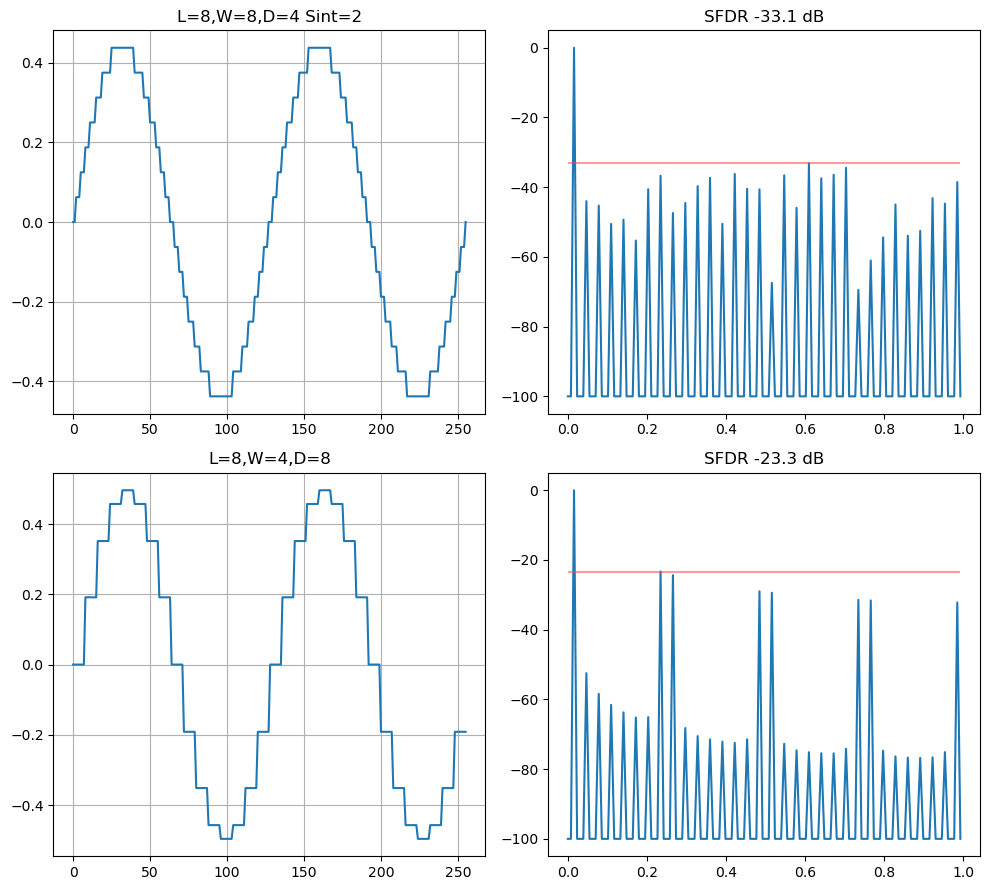

In [63]:
def fig1(psint):
    osc1 = Nco(8,8,4,psint)
    osc2 = Nco(8,4,8,psint)
    m1 = osc1.muestras(256)/(2**4)
    m2 = osc2.muestras(256)/(2**8)
    plt.figure(figsize=(10,9),dpi=100)
    plt.subplot(2,2,1)
    plt.plot(m1)
    plt.grid()
    plt.title("L=8,W=8,D=4 Sint=%d"%psint)
    plt.subplot(2,2,2)
    espectrograma(m1,len(m1),mag_minima=-100,normaliza=True)
    plt.subplot(2,2,3)
    plt.plot(m2)
    plt.grid()
    plt.title("L=8,W=4,D=8")
    plt.subplot(2,2,4)
    espectrograma(m2,len(m2),mag_minima=-100,normaliza=True)

    plt.show()
fig1(2)

In [18]:
class Nco2(Nco):
    def muestras_mod_fase(self,deltas_acumulador):
        n = len(deltas_acumulador)
        valores_acumulador = self.acumulador + self.psint*np.arange(n,dtype='u4') + np.uint32(deltas_acumulador) # 0 a n-1
        muestras = self._tabla_onda(valores_acumulador)
        self.acumulador = self.acumulador + np.uint32(n)*self.psint
        return muestras
    def muestras_mod_amplitud_fase(self,amplitudes,deltas_fase = None):
        assert np.issubdtype(amplitudes.dtype,np.integer)
        n = len(amplitudes)
        if deltas_fase is None:
            x = self.muestras(n)
        else:
            x = self.muestras_mod_fase(deltas_fase)
        return np.int32(((np.int64(x)*np.int64(amplitudes))>>(self._nbits_tabla_o-1)))

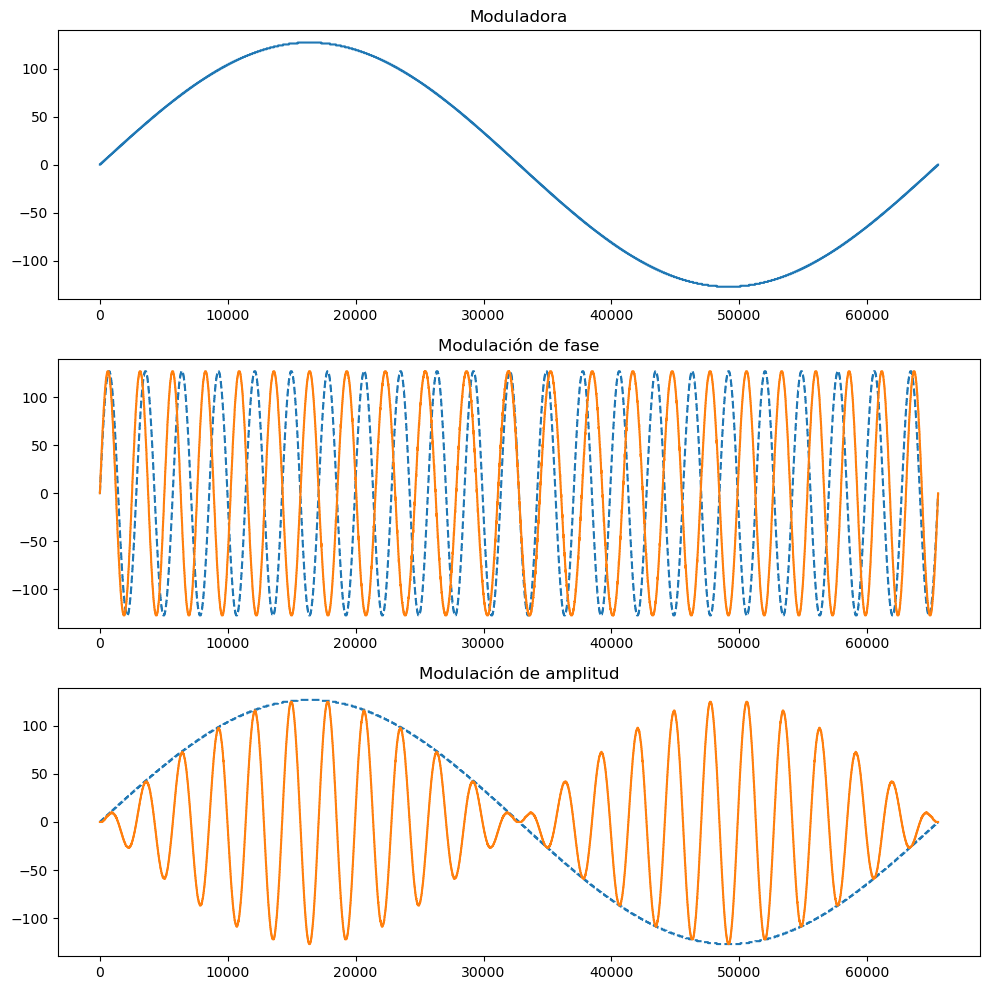

In [19]:
def fig2(fb,fc,nf,nti,nto):
    osc3 = Nco2(nf,nti,nto,fc)
    osc4 = Nco(nf,nti,nto,fb)

    plt.figure(figsize=(10,10),dpi=100)
    n = 2**nf
    x = osc4.muestras(n)
    k = np.arange(n)
    plt.subplot(3,1,1)
    plt.plot(k,x)
    plt.title("Moduladora")
    plt.subplot(3,1,2)
    plt.plot(k,osc3.muestras(n),'--')
    plt.plot(k,osc3.muestras_mod_fase(x*2**(nf-nto)))
    plt.title("Modulación de fase")
    plt.subplot(3,1,3)
    plt.plot(k,x,'--')
    plt.plot(k,osc3.muestras_mod_amplitud_fase(x))
    plt.title("Modulación de amplitud")
    plt.show()
fig2(1,23,16,16,8)

In [20]:
def sos_filtro_antialias(oversample):
    fcorte = 1/2*oversample
    fstop  = 1/2 if oversample > 1 else 11/20
    return sig.filter_design.butter(*sig.filter_design.buttord(1/(2*oversample),.5,1,60),'low',output='sos')

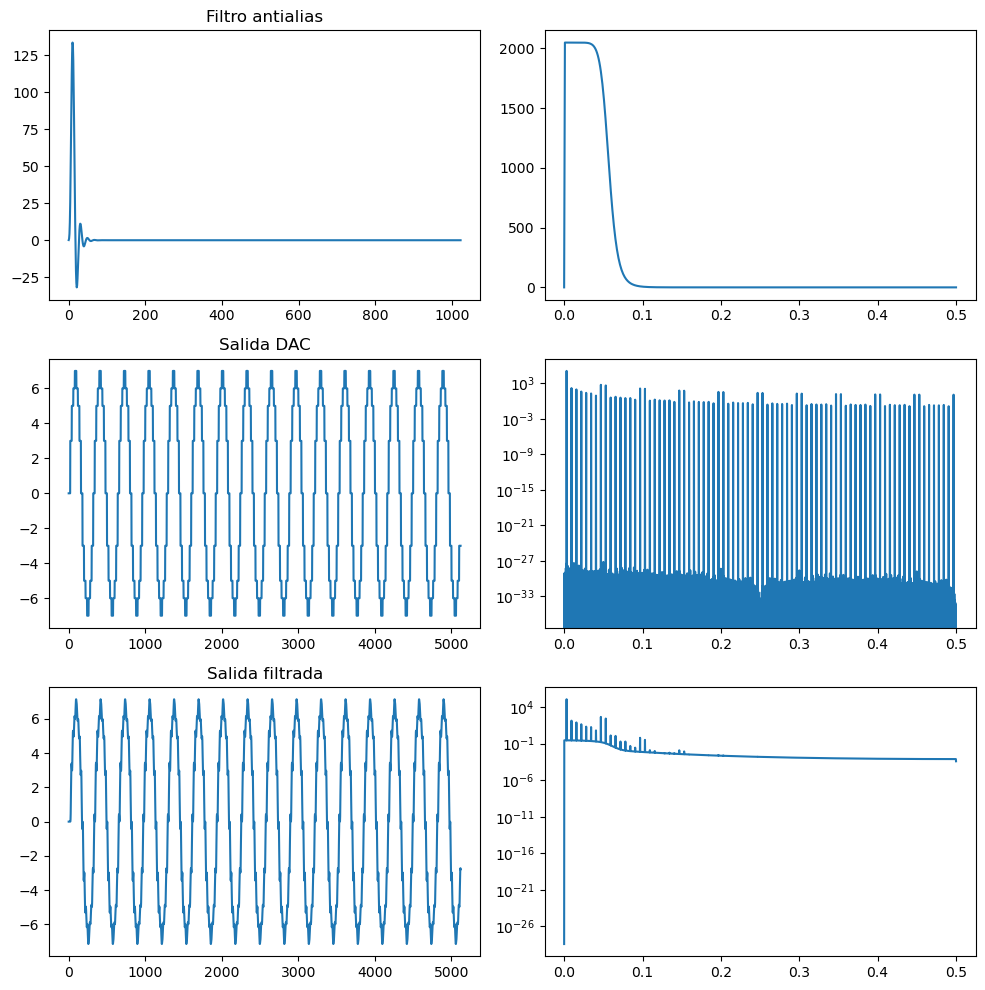

In [26]:
def fig3(ps,nf,nti,nto,oversample=5):
    sos_antialias=sos_filtro_antialias(oversample)
    n = (2**nf)
    osc = Nco(nf,nti,nto,ps)
    x = np.repeat(osc.muestras(n),oversample)
    xaa = sig.sosfilt(sos_antialias,x)
    h = sig.sosfilt(sos_antialias,(1024,)+(0,)*1023)
    plt.figure(figsize=(10,10),dpi=100)
    plt.subplot(3,2,1)
    plt.plot(h)
    plt.title("Filtro antialias")
    plt.subplot(3,2,2)
    plt.plot(*sig.periodogram(h))
    plt.subplot(3,2,3)
    plt.plot(x)
    plt.title("Salida DAC")
    plt.subplot(3,2,4)
    plt.semilogy(*sig.periodogram(x))
    plt.subplot(3,2,5)
    plt.plot(xaa)
    plt.title("Salida filtrada")
    plt.subplot(3,2,6)
    plt.semilogy(*sig.periodogram(xaa))
    plt.show()
fig3(16,10,4,4)

In [27]:
class Nco_impar(Nco):
    def muestras(self,n):
        k = np.arange(n,dtype='u4')
        adicional = (k+np.uint32(self.acumulador&1))//np.uint32(2)
        valores_acumulador = self.acumulador + self.psint*k + adicional # 0 a n-1
        muestras = self._tabla_onda(valores_acumulador)
        self.acumulador = self.acumulador + np.uint32(n)*self.psint + np.uint32((n+(self.acumulador&1))//2)
        return muestras

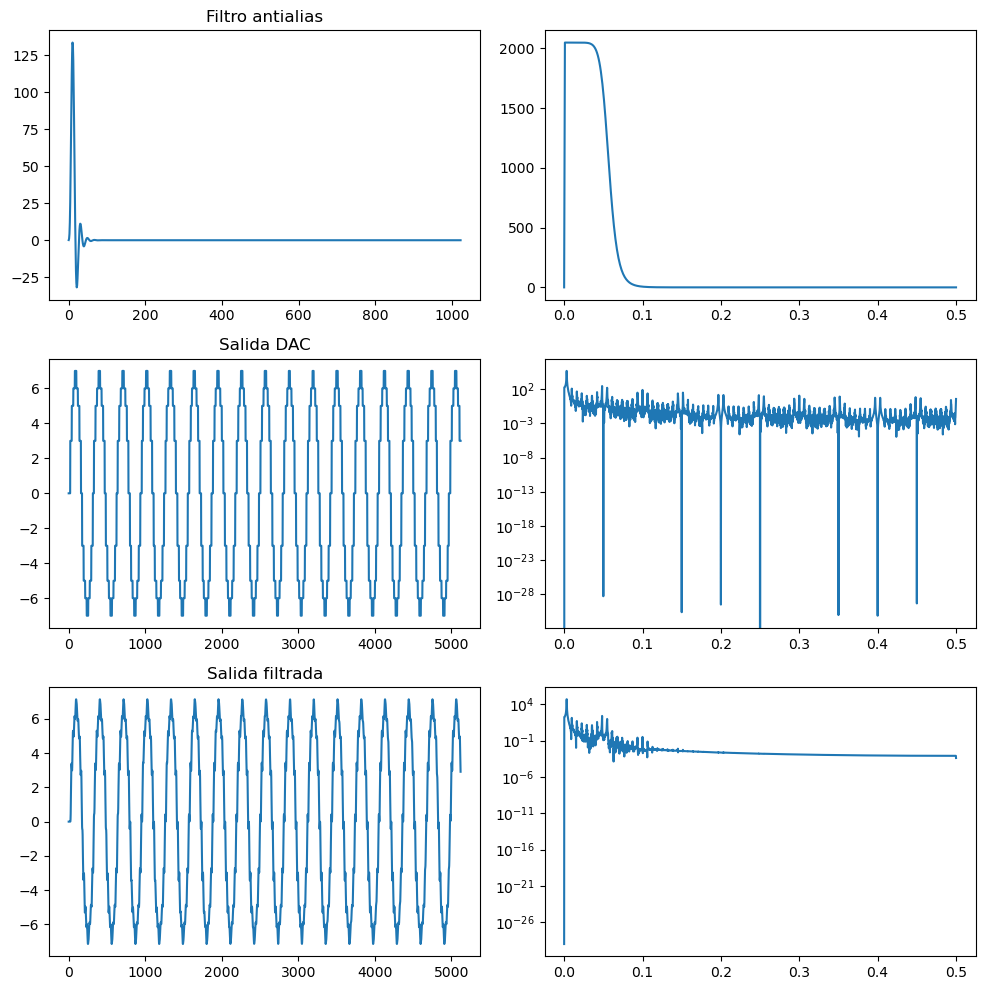

In [28]:
def fig4(ps,nf,nti,nto,oversample=5):
    filtro_antialias=sos_filtro_antialias(oversample)
    n = (2**nf)
    osc = Nco_mitigacion_ruido(nf,nti,nto,ps)
    x = np.repeat(osc.muestras(n),oversample)
    xaa = sig.sosfilt(filtro_antialias,x)
    h = sig.sosfilt(filtro_antialias,(1024,)+(0,)*1023)
    plt.figure(figsize=(10,10),dpi=100)
    plt.subplot(3,2,1)
    plt.plot(h)
    plt.title("Filtro antialias")
    plt.subplot(3,2,2)
    plt.plot(*sig.periodogram(h))
    plt.subplot(3,2,3)
    plt.plot(x)
    plt.title("Salida DAC")
    plt.subplot(3,2,4)
    plt.semilogy(*sig.periodogram(x))
    plt.subplot(3,2,5)
    plt.plot(xaa)
    plt.title("Salida filtrada")
    plt.subplot(3,2,6)
    plt.semilogy(*sig.periodogram(xaa))
    plt.show()
fig4(16,10,4,4)

C:\Users\Fernando\AppData\Local\Temp\ipykernel_15828\1727267867.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return s[-1]/s[-2]
C:\Users\Fernando\AppData\Local\Temp\ipykernel_15828\1727267867.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return s[-1]/s[-2]


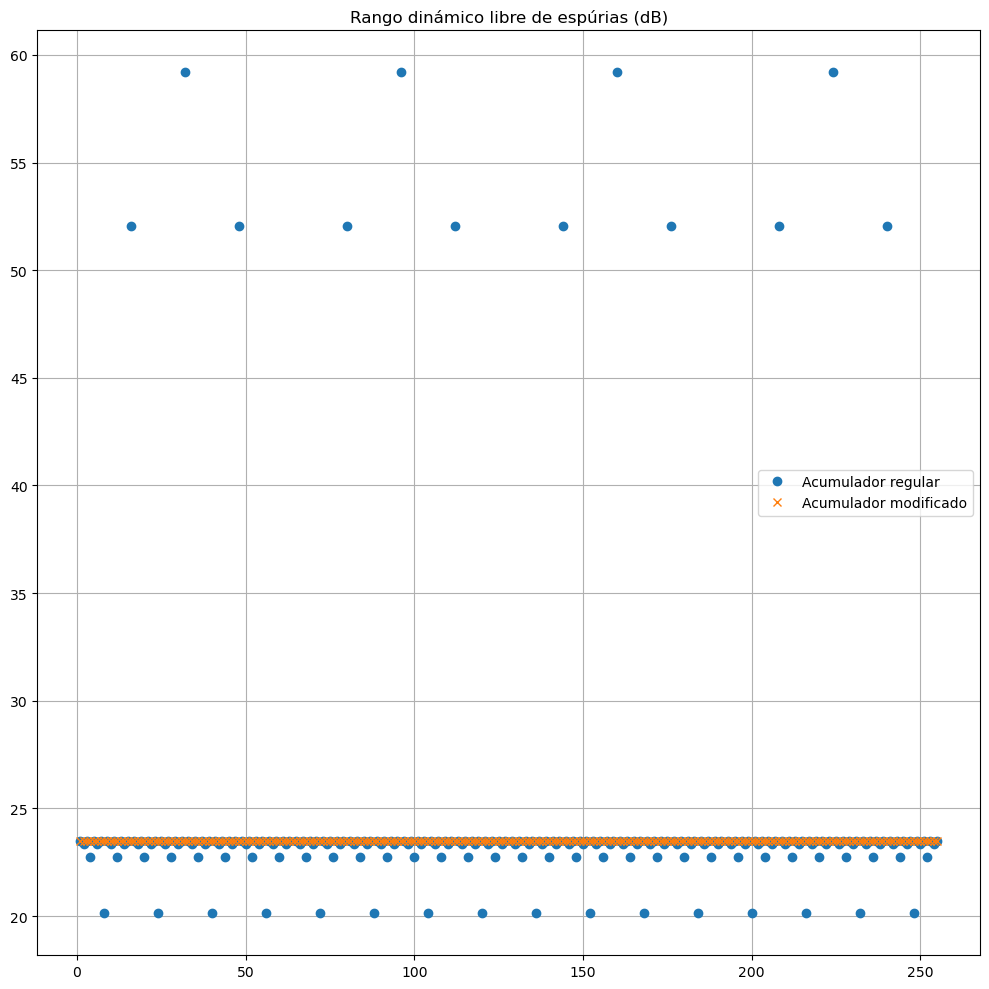

In [34]:
def fig5(L,W,D,psmax=None):
    if psmax is None:
        psmax = 2**(L-1)
    osc1 = Nco(L,W,D,1)
    osc2 = Nco_mitigacion_ruido(L,W,D,1)
    nf = 2**(L+1)
    def sfdr(psint,osc):
        osc.psint = psint
        _,s=sig.periodogram(osc.muestras(nf),window='rect')
        s.sort()
        return s[-1]/s[-2]
    psints = range(1,psmax)
    x1 = 10*np.log10([sfdr(psint,osc1) for psint in psints])
    x2 = 10*np.log10([sfdr(psint,osc2) for psint in psints])
    plt.figure(figsize=(10,10),dpi=100)
    plt.grid()
    plt.plot(psints,x1,'o')
    plt.plot(psints,x2,'x')
    plt.title("Rango dinámico libre de espúrias (dB)")
    plt.legend(("Acumulador regular","Acumulador modificado"),loc='center right')
fig5(8,4,8,256)

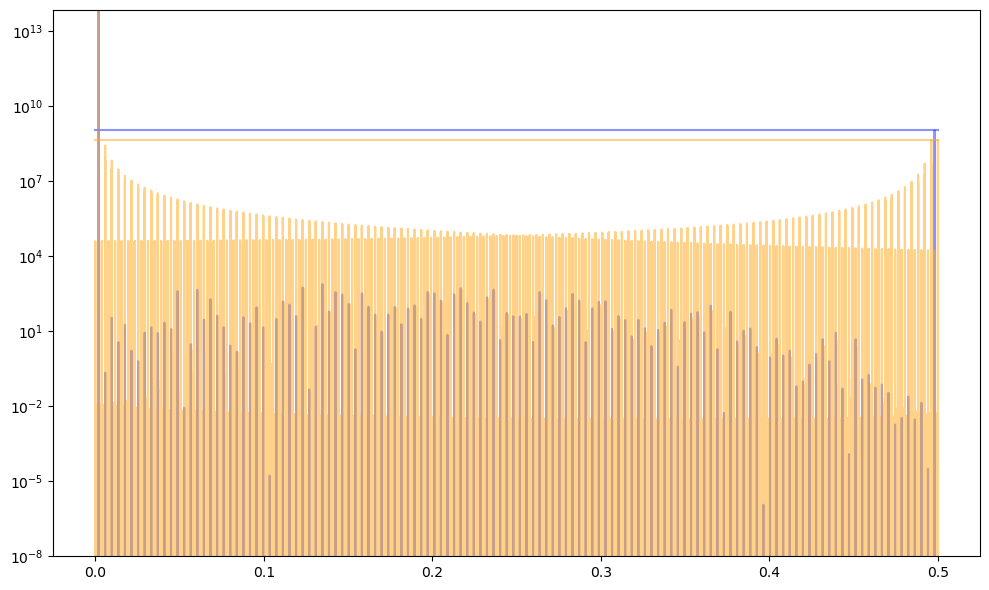

In [35]:
def fig6(ps,L,W,D,oversample=5):
    """
    ps: Palabra de sintonía
    L : Número de bits acumulador
    W : Número de bits de dirección en tabla seno
    D : Número de bits de conversor A/D
    oversample: Sobremuestreo para simular salida analógica
    """
    def espuria_max(X):
        Y = X.copy()
        Y.sort()
        return Y[-2]
    n = 2**(L+1)
    osc1 = Nco(L,W,D,ps)
    osc2 = Nco_mitigacion_ruido(L,W,D,ps)
    x1 = np.repeat(osc1.muestras(n),oversample)
    x2 = np.repeat(osc2.muestras(n),oversample)
    F,X1 = sig.periodogram(x1,window='rect',fs=oversample)
    _,X2 = sig.periodogram(x2,window='rect',fs=oversample)
    k = (F>0.5).argmax()
    X_max = max(X1.max(),X2.max())
    X1_sm = espuria_max(X1[:k])
    X2_sm = espuria_max(X2[:k])
    plt.figure(figsize=(10,6),dpi=100)
    pfun = plt.semilogy
    pfun(F[:k],X1[:k],color='#23F8')
    pfun((F[0],F[k-1]),(X1_sm,X1_sm),color='#23F8')
    pfun(F[:k],X2[:k],color='#FA28')
    pfun((F[0],F[k-1]),(X2_sm,X2_sm),color='#FA28')
    plt.ylim(1e-8,X_max)
    plt.show()
fig6(128,16,8,16,oversample=8)